In [35]:
include("astrobee_se3_script.jl")
using Plots

N = 200
MAX_ITERATIONS_NB = 100

model = Astrobee()

Xp,Up = initialize_trajectory(model, N)
X, U  = copy(Xp) .+ 2., copy(Up) .+ 2.

SCPproblem = GuSTOProblem(model, N, Xp, Up)

x_dim, u_dim = model.x_dim, model.u_dim

Delta0, omega0, omegamax, 
    epsilon, rho0, rho1, 
    beta_succ, beta_fail, gamma_fail, 
    convergence_threshold = get_initial_gusto_parameters(model)

Delta = Delta0
omega = omega0

# X = zeros(x_dim, N)
# U = zeros(u_dim, N-1)
println("oh yeah")

oh yeah


In [36]:

#     problem = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

In [37]:
gamma_fail

5.0

In [38]:
beta_fail

0.1

In [39]:
include("astrobee_se3_script.jl")

X_all, U_all, x_shooting_all = [], [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

B_success = false
it = 0

while it<MAX_ITERATIONS_NB && 
        !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
            convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
        omega<omegamax
    println("-----------")
    println("Iteration $it")
    println("metric=$(convergence_metric(model,X,U,Xp,Up))")
    println("-----------")
    
#     omega, Delta = SCPproblem.omega, SCPproblem.Delta
    
    Xp = copy(X)
    Up = copy(U)
    
    model.f, model.A, model.B = compute_dynamics(model, Xp, Up)
    
    reset_problem(SCPproblem, model)
    set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    JuMP.optimize!(SCPproblem.solver_model)    
    p0 = get_initial_constraint_dual_variable(SCPproblem, model)
    println("dual variables:", p0)
    # get solution
    X_sol = JuMP.value.(SCPproblem.X)
    U_sol = JuMP.value.(SCPproblem.U)
    
    # try shooting
    #x_shooting, sol_newton = solve_shooting(SCPproblem, model, p0)
#     x_shooting = solve_shooting_once(SCPproblem, model, p0)
    #push!(x_shooting_all, x_shooting)
    
    # -----------
    # GuSTO Logic
    if it > 3
        if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
            rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

            if rho > rho1
                println("Reject solution.")
                Delta = beta_fail * Delta
                omega     = omega
                B_success = false

            else
                println("Accept solution.")
                X = copy(X_sol)
                U = copy(U_sol)
                B_success = true
                if rho < rho0
                    Delta = min(beta_succ*Delta, Delta0)
                else
                    Delta = Delta
                end
                if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                    omega = omega0
                else
                    println("Solution does not satisfy state constraints, increasing omega.")
                    omega = gamma_fail * omega
                end
            end

        else
            println("Reject solution (Outside trust region)")
            Delta = Delta
            omega     = gamma_fail * omega
            B_success = false
        end
    else # always accept first solution
        X = copy(X_sol)
        U = copy(U_sol)
    end
        
                    
    # -----------

    push!(X_all, copy(X))
    push!(U_all, copy(U))
                    
    
    it += 1
    
    println("Parameters:")
    println("omega=$omega")
    println("delta=$Delta")
end


-----------
Iteration 0
metric=94.24868789068172
-----------
dual variables:[-0.6143, -0.763264, -0.692929, -1.32912, -1.42887, -1.38553, -7.74621e-5, -0.00160596, -0.00171843, -0.0018033, -0.00187685, -0.00168563, -0.00253515]
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=85.69283925731985
-----------
dual variables:[-0.00262153, 0.000336009, -0.00141663, -0.116069, 0.051355, -0.0400014, -2.25439e-8, -9.4468e-7, -1.18374e-6, -1.02632e-6, 1.91628e-5, 1.43004e-5, 1.08555e-5]
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 2
metric=367.6266385122189
-----------
dual variables:[-0.00242557, 0.000283454, -0.00207457, -0.106359, 0.0548355, -0.0515601, 7.87167e-6, 3.02098e-6, -3.03454e-6, -2.2653e-6, 1.43579e-5, 5.83871e-5, -5.06334e-5]
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 3
metric=143.88553063277178
-----------
dual variables:[-0.00210829, 0.000435127, -0.00247329, -0.0983601, 0.0585999, -0.0568113, 5.78245e-6, 8.10115e-6, -3.22035e-6, -1.157

In [40]:
gamma_fail

5.0

In [41]:
init_duals = get_initial_constraint_dual_variable(SCPproblem, model)

13-element Array{Float64,1}:
 -0.0005632874627733523 
  0.001918124576067724  
 -0.00227748378286541   
 -0.06392924746777515   
  0.09153331352094289   
 -0.05232598341725057   
  1.2750047122430756e-11
  2.615347840183271e-12 
 -2.3669649948847147e-6 
  2.7102390289670543e-8 
  6.559618931847634e-5  
  1.1232817488565844e-10
 -1.258104630209546e-10 

In [50]:
include("astrobee_se3_script.jl")
 
sol_newton = solve_shooting(SCPproblem, model, get_initial_constraint_dual_variable(SCPproblem, model))
#x_shooting = solve_shooting_once(SCPproblem, model, sol_newton.zero)

sol_minpack.converged = false


(Any[], Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell (Expert)
 * Starting Point: [-0.000563287, 0.00191812, -0.00227748, -0.0639292, 0.0915333, -0.052326, 1.275e-11, 2.61535e-12, -2.36696e-6, 2.71024e-8, 6.55962e-5, 1.12328e-10, -1.2581e-10]
 * Zero: [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]
 * Inf-norm of residuals: NaN
 * Convergence: false
 * Message: iteration is not making good progress, measured by improvement from last 10 iterations
 * Total time: 3.336555 seconds
 * Function Calls: 0
 * Jacobian Calls (df/dx): 0)

In [43]:
xN = x_shooting[:,end]

for i = 1:x_dim
    Fi = model.x_final[i] - xN[i]
    @show Fi
end

BoundsError: BoundsError: attempt to access 0-element Array{Any,1} at index [1]

In [44]:

    for x_shooting in x_shooting_all
        if size(x_shooting,1) > 1
        @show minimum(x_shooting)
        end
end

In [45]:
x_shooting_all

0-element Array{Any,1}

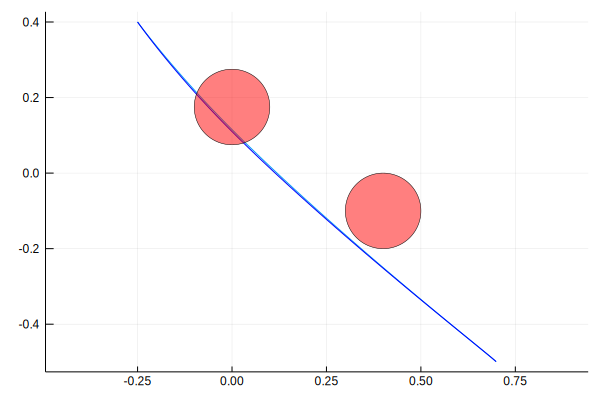

In [46]:
include("astrobee_se3_script.jl")
#plot(X[1,:],X[2,:])

plot_solutions(SCPproblem, model, X_all[end-1:end], U_all[end-1:end]; x_shooting_all=x_shooting_all)

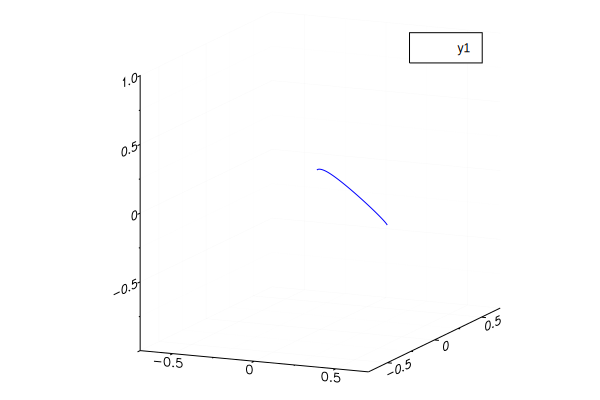

In [47]:
X = X_all[end]
# Xs = x_shooting_all[2]
 fig = plot(X[1,:], X[2,:], X[3,:]; c=:blue, lims = (-0.7,0.7))
# plot!(fig, Xs[1,:], Xs[2,:], Xs[3,:]; c=:red)

xlims = (0,10)
zlims = (0,10)
fig

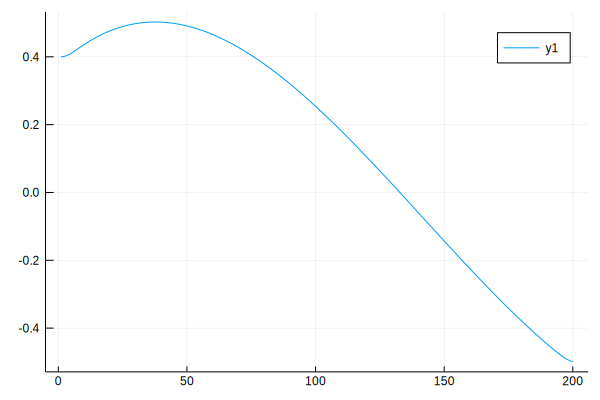

In [48]:
idx = [1,2]
x = X_all[2][1,:]
y = X_all[2][2,:]
z = X_all[2][3,:]
# plot(x,  y)
plot(1:N, y)